# Importation, nettoyage et formattage des données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import functools as fc
from datetime import datetime


In [2]:
order_payments = pd.read_csv('olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
orders_dataset = pd.read_csv('olist_orders_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')

customers = pd.read_csv('olist_customers_dataset.csv')
geolocation = pd.read_csv('olist_geolocation_dataset.csv')
products_dataset = pd.read_csv('olist_products_dataset.csv')
sellers_dataset = pd.read_csv('olist_sellers_dataset.csv')
category_name = pd.read_csv('product_category_name_translation.csv')

raw_datasets = [customers,geolocation,order_items,order_payments,order_reviews,orders_dataset,sellers_dataset,category_name,products_dataset]
order_id_link = [order_payments,order_reviews,orders_dataset,order_items]

In [3]:
for dataset in raw_datasets :
    
    print(dataset.info())
    print(dataset.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None
                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code

In [4]:
df_1 = pd.merge(customers,orders_dataset,how='outer',on='customer_id')


df_2 = pd.merge(df_1,order_reviews,how='outer',on='order_id')

df_3 = pd.merge(df_2,order_payments,how='outer',on='order_id')

raw = pd.merge(df_3,order_items,how='outer',on='order_id')

raw.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 119143 entries, 0 to 119142
Data columns (total 28 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    119143 non-null  object 
 1   customer_unique_id             119143 non-null  object 
 2   customer_zip_code_prefix       119143 non-null  int64  
 3   customer_city                  119143 non-null  object 
 4   customer_state                 119143 non-null  object 
 5   order_id                       119143 non-null  object 
 6   order_status                   119143 non-null  object 
 7   order_purchase_timestamp       119143 non-null  object 
 8   order_approved_at              118966 non-null  object 
 9   order_delivered_carrier_date   117057 non-null  object 
 10  order_delivered_customer_date  115722 non-null  object 
 11  order_estimated_delivery_date  119143 non-null  object 
 12  review_id                     

In [ ]:
def create_dataset(raw,date):
    raw['order_purchase_timestamp']= pd.to_datetime(raw['order_purchase_timestamp'])
    df = raw[raw['order_purchase_timestamp']<date]
    df = df[df['order_status']=='delivered']
    df = df.groupby(['customer_unique_id','order_id']).agg({
    'price' : 'sum',
    'review_score' : 'mean',
    'order_purchase_timestamp' : 'min'
}).reset_index()
    df = pd.pivot_table(df,
                        values=df.drop(columns='customer_unique_id').columns,
                        index=['customer_unique_id'],
                        aggfunc={
                            'order_id': len,
                            'price' : [sum,np.mean],
                            'review_score' : np.mean,
                            'order_purchase_timestamp' : max
                        }).reset_index()
    df.columns = df.columns.droplevel(0)
    df.columns=['customer_unique_id','order_count','last_order','mean_payment_item','total_payment_item','mean_review']
    df['days_since_last_order'] = ((max(df['last_order']) - df['last_order']) / pd.Timedelta(1, unit='d')).round()
    df = df[df['total_payment_item']<5000]
    return df


    
    

In [5]:
raw['order_purchase_timestamp'].max()

'2018-10-17 17:30:18'

In [6]:
raw['payment_installments'].value_counts()

1.0     59446
2.0     13838
3.0     11889
4.0      8072
10.0     6976
5.0      6097
8.0      5120
6.0      4674
7.0      1848
9.0       739
12.0      168
15.0       93
18.0       38
24.0       34
11.0       26
20.0       21
13.0       19
14.0       16
17.0        8
16.0        7
21.0        6
0.0         3
22.0        1
23.0        1
Name: payment_installments, dtype: int64

In [7]:
len(raw['product_id'].unique())

32952

In [8]:
raw.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,1.0,credit_card,2.0,146.87,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,...,1.0,credit_card,8.0,335.48,1.0,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,...,1.0,credit_card,7.0,157.73,1.0,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,...,1.0,credit_card,1.0,173.30,1.0,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,...,1.0,credit_card,8.0,252.25,1.0,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25


In [9]:
len(raw['customer_unique_id'].unique())

96096

In [10]:
len(raw['customer_id'].unique())

99441

In [11]:
df_check = raw[['customer_unique_id','order_id']].drop_duplicates().groupby('customer_unique_id')['order_id'].count()

In [12]:
test = raw[['customer_unique_id', 'order_id']].value_counts()
test

customer_unique_id                order_id                        
9a736b248f67d166d2fbb006bcb877c3  895ab968e7bb0d5659d16cd74cd1650c    63
6fbc7cdadbb522125f4b27ae9dee4060  fedcd9f7ccdc8cba3a18defedd1a5547    38
8af7ac63b2efbcbd88e5b11505e8098a  fa65dad1b0e818e3ccc5cb0e39231352    29
569aa12b73b5f7edeaa6f2a01603e381  ccf804e764ed5650cd8759557269dc13    26
90807fdb59eec2152bc977feeb6e47e7  6d58638e32674bebee793a47ac4cbadc    24
                                                                      ..
5ac6468b01b29ea7238103d44092c65a  00fcf938cde49ae138942b632ed62393     1
5ac547c923c50219dcb24c3cd925b1b8  c58478c0a746d4188108e2ec71001110     1
5ac53376e1062bedef136a6928961d44  865897de02d9ded27e7598dc5013f98e     1
5ac4e37b3dbd8175a5f76dac1c2e2292  5af3995b6e2291d7ce8086db20960dd8     1
ffffd2657e2aad2907e67c3e9daecbeb  f79a35da168301ae56922475da21117b     1
Length: 99441, dtype: int64

In [13]:
len(df_check[df_check>1])/len(df_check)

0.031187562437562436

In [14]:
df_check[df_check>12]

customer_unique_id
8d50f5eadf50201ccdcedfb9e2ac8455    17
Name: order_id, dtype: int64

In [15]:
raw.loc[raw['customer_unique_id']=='8d50f5eadf50201ccdcedfb9e2ac8455',['order_id']].duplicated()

17017     False
18370     False
19960     False
43391     False
45721     False
48127     False
58223     False
63056     False
70306     False
81424     False
87204     False
89393     False
99987     False
102552    False
108223    False
112211    False
115823    False
dtype: bool

In [16]:
len(raw[raw['order_status']!='delivered'])/len(raw['order_status'].isna()==False)

0.028705001552755932

In [17]:
raw = raw[raw['order_status']=='delivered']

In [18]:
pd.set_option('display.max_columns', None)
raw.loc[((raw['customer_unique_id']=='a96d5cfa0d3181817e2b946f921ea021') &(raw['order_id']=='aaff8afa47c8426e414a6d908a97713c'))]

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
22,690172ab319622688d3b4df42f676898,a96d5cfa0d3181817e2b946f921ea021,74914,aparecida de goiania,GO,aaff8afa47c8426e414a6d908a97713c,delivered,2017-10-15 11:08:48,2017-10-15 11:25:49,2017-10-16 21:36:29,2017-10-25 22:30:58,2017-11-06 00:00:00,7ed1089c451484fd5e7ee0a4036af90d,1.0,NaN,Bom dia eu fiz uma compra de 03 peças só mim e...,2017-10-26 00:00:00,2017-10-27 09:19:26,1.0,credit_card,2.0,232.71,1.0,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2017-10-19 11:25:49,59.9,17.67
23,690172ab319622688d3b4df42f676898,a96d5cfa0d3181817e2b946f921ea021,74914,aparecida de goiania,GO,aaff8afa47c8426e414a6d908a97713c,delivered,2017-10-15 11:08:48,2017-10-15 11:25:49,2017-10-16 21:36:29,2017-10-25 22:30:58,2017-11-06 00:00:00,7ed1089c451484fd5e7ee0a4036af90d,1.0,NaN,Bom dia eu fiz uma compra de 03 peças só mim e...,2017-10-26 00:00:00,2017-10-27 09:19:26,1.0,credit_card,2.0,232.71,2.0,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2017-10-19 11:25:49,59.9,17.67
24,690172ab319622688d3b4df42f676898,a96d5cfa0d3181817e2b946f921ea021,74914,aparecida de goiania,GO,aaff8afa47c8426e414a6d908a97713c,delivered,2017-10-15 11:08:48,2017-10-15 11:25:49,2017-10-16 21:36:29,2017-10-25 22:30:58,2017-11-06 00:00:00,7ed1089c451484fd5e7ee0a4036af90d,1.0,NaN,Bom dia eu fiz uma compra de 03 peças só mim e...,2017-10-26 00:00:00,2017-10-27 09:19:26,1.0,credit_card,2.0,232.71,3.0,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2017-10-19 11:25:49,59.9,17.67


In [19]:
raw[raw['customer_unique_id']=='0a0a92112bd4c708ca5fde585afaa872']

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
7444,1617b1357756262bfa56ab541c47bc16,0a0a92112bd4c708ca5fde585afaa872,20080,rio de janeiro,RJ,03caa2c082116e1d31e67e9ae3700499,delivered,2017-09-29 15:24:52,2017-10-02 15:28:20,2017-10-10 15:43:17,2017-10-17 18:22:29,2017-10-23 00:00:00,211fa81a22870cc634265ea85b751e40,1.0,NaN,"Peço por favor verificar a entrega do pedido, ...",2017-10-18 00:00:00,2017-10-19 13:10:39,1.0,credit_card,1.0,13664.08,1.0,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
7445,1617b1357756262bfa56ab541c47bc16,0a0a92112bd4c708ca5fde585afaa872,20080,rio de janeiro,RJ,03caa2c082116e1d31e67e9ae3700499,delivered,2017-09-29 15:24:52,2017-10-02 15:28:20,2017-10-10 15:43:17,2017-10-17 18:22:29,2017-10-23 00:00:00,211fa81a22870cc634265ea85b751e40,1.0,NaN,"Peço por favor verificar a entrega do pedido, ...",2017-10-18 00:00:00,2017-10-19 13:10:39,1.0,credit_card,1.0,13664.08,2.0,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
7446,1617b1357756262bfa56ab541c47bc16,0a0a92112bd4c708ca5fde585afaa872,20080,rio de janeiro,RJ,03caa2c082116e1d31e67e9ae3700499,delivered,2017-09-29 15:24:52,2017-10-02 15:28:20,2017-10-10 15:43:17,2017-10-17 18:22:29,2017-10-23 00:00:00,211fa81a22870cc634265ea85b751e40,1.0,NaN,"Peço por favor verificar a entrega do pedido, ...",2017-10-18 00:00:00,2017-10-19 13:10:39,1.0,credit_card,1.0,13664.08,3.0,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
7447,1617b1357756262bfa56ab541c47bc16,0a0a92112bd4c708ca5fde585afaa872,20080,rio de janeiro,RJ,03caa2c082116e1d31e67e9ae3700499,delivered,2017-09-29 15:24:52,2017-10-02 15:28:20,2017-10-10 15:43:17,2017-10-17 18:22:29,2017-10-23 00:00:00,211fa81a22870cc634265ea85b751e40,1.0,NaN,"Peço por favor verificar a entrega do pedido, ...",2017-10-18 00:00:00,2017-10-19 13:10:39,1.0,credit_card,1.0,13664.08,4.0,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
7448,1617b1357756262bfa56ab541c47bc16,0a0a92112bd4c708ca5fde585afaa872,20080,rio de janeiro,RJ,03caa2c082116e1d31e67e9ae3700499,delivered,2017-09-29 15:24:52,2017-10-02 15:28:20,2017-10-10 15:43:17,2017-10-17 18:22:29,2017-10-23 00:00:00,211fa81a22870cc634265ea85b751e40,1.0,NaN,"Peço por favor verificar a entrega do pedido, ...",2017-10-18 00:00:00,2017-10-19 13:10:39,1.0,credit_card,1.0,13664.08,5.0,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
7449,1617b1357756262bfa56ab541c47bc16,0a0a92112bd4c708ca5fde585afaa872,20080,rio de janeiro,RJ,03caa2c082116e1d31e67e9ae3700499,delivered,2017-09-29 15:24:52,2017-10-02 15:28:20,2017-10-10 15:43:17,2017-10-17 18:22:29,2017-10-23 00:00:00,211fa81a22870cc634265ea85b751e40,1.0,NaN,"Peço por favor verificar a entrega do pedido, ...",2017-10-18 00:00:00,2017-10-19 13:10:39,1.0,credit_card,1.0,13664.08,6.0,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
7450,1617b1357756262bfa56ab541c47bc16,0a0a92112bd4c708ca5fde585afaa872,20080,rio de janeiro,RJ,03caa2c082116e1d31e67e9ae3700499,delivered,2017-09-29 15:24:52,2017-10-02 15:28:20,2017-10-10 15:43:17,2017-10-17 18:22:29,2017-10-23 00:00:00,211fa81a22870cc634265ea85b751e40,1.0,NaN,"Peço por favor verificar a entrega do pedido, ...",2017-10-18 00:00:00,2017-10-19 13:10:39,1.0,credit_card,1.0,13664.08,7.0,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:2

In [20]:
raw = raw[['order_id','price','review_score','customer_unique_id','order_purchase_timestamp','freight_value','order_item_id']]

In [21]:
raw['order_purchase_timestamp'] = pd.to_datetime(raw['order_purchase_timestamp'])

In [22]:
raw.duplicated().sum()

5274

In [23]:
raw[raw.duplicated()]

,order_id,price,review_score,customer_unique_id,order_purchase_timestamp,freight_value,order_item_id
19,17825f24877a9289214c301ae0c9424b,89.90,NaN,7f3a72e8f988c6e735ba118d54f47458,2017-05-11 13:48:47,12.13,1.0
39,a9119eb77d6200811953803a7b6539e1,30.50,5.0,ef07ba9aa5226f77264ffa5762b2280b,2018-03-12 13:07:03,15.23,1.0
61,a6917b5d71e0e9bc434e9228db8daeb2,788.42,1.0,d85547cd859833520b311b4458a14c1c,2017-06-09 15:46:17,21.28,1.0
78,db97652cf517d2cd03db63dec489ca62,19.90,3.0,b3548d0cec408ae13d143bb4eeebaa6c,2017-10-01 08:57:03,7.78,1.0
79,db97652cf517d2cd03db63dec489ca62,19.90,3.0,b3548d0cec408ae13d143bb4eeebaa6c,2017-10-01 08:57:03,7.78,1.0
...,...,...,...,...,...,...,...
119116,357b4b724bbf34f1d64b1c5dfdc88120,29.90,5.0,b96d6a178adbabf269fd843b37327798,2018-01-24 02:22:12,14.10,2.0
119125,e86b1b2dd48839d7351406434afb578d,19.90,4.0,4452b8ef472646c4cc042cb31a291f3b,2017-11-25 00:31:20,12.48,1.0
119126,e86b1b2dd48839d7351406434afb578d,19.90,4.0,4452b8ef472646c4cc042cb31a291f3b,2017-11-25 00:31:20,12.48,1.0
119130,51c6d2f460589fa7b65f2da51e860206,167.99,1.0,82d46759af0369aad49084bacf85a6c3,2017-11-14 12:04:09,31.93,1.0


# Première agglomération : par commande

In [24]:
raw = raw.groupby(['customer_unique_id','order_id']).agg({
    'price' : 'sum',
    'freight_value' : 'sum',
    'review_score' : 'mean',
    'order_purchase_timestamp' : 'min',
    'order_item_id' : 'max'
}).reset_index()
    
raw  

,customer_unique_id,order_id,price,freight_value,review_score,order_purchase_timestamp,order_item_id
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,129.90,12.00,5.0,2018-05-10 10:56:27,1.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,18.90,8.29,4.0,2018-05-07 11:11:27,1.0
2,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,69.00,17.22,3.0,2017-03-10 21:05:03,1.0
3,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,25.99,17.63,4.0,2017-10-12 20:29:41,1.0
4,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,180.00,16.89,5.0,2017-11-14 19:45:42,1.0
...,...,...,...,...,...,...,...
96473,fffcf5a5ff07b0908bd4e2dbc735a684,725cf8e9c24e679a8a5a32cb92c9ce1e,1570.00,497.42,5.0,2017-06-08 21:00:36,2.0
96474,fffea47cd6d3cc0a88bd621562a9d061,c71b9252fd7b3b263aaa4cb09319a323,64.89,19.69,4.0,2017-12-10 20:07:56,1.0
96475,ffff371b4d645b6ecea244b27531430a,fdc45e6c7555e6cb3cc0daca2557dbe1,89.90,22.56,5.0,2017-02-07 15:49:16,1.0
96476,ffff5962728ec6157033ef9805bacc48,94d3ee0bc2a0af9d4fa47a4d63616e8d,115.00,18.69,5.0,2018-05-02 15:17:41,1.0


In [25]:
raw.loc[((raw['customer_unique_id']=='a96d5cfa0d3181817e2b946f921ea021') &(raw['order_id']=='aaff8afa47c8426e414a6d908a97713c'))]

,customer_unique_id,order_id,price,freight_value,review_score,order_purchase_timestamp,order_item_id
63927,a96d5cfa0d3181817e2b946f921ea021,aaff8afa47c8426e414a6d908a97713c,179.7,53.01,1.0,2017-10-15 11:08:48,3.0


In [26]:
raw.duplicated().sum()

0

# Deuxième agglomération : par client

In [27]:
data = pd.pivot_table(raw,
                        values=raw.drop(columns='customer_unique_id').columns,
                        index=['customer_unique_id'],
                        aggfunc={
                            'order_id': len,
                            'price' : [sum,np.mean],
                            'review_score' : np.mean,
                            'order_purchase_timestamp' : max,
                            'freight_value' : np.mean,
                            'order_item_id' : np.mean
                        }).reset_index()

data

customer_unique_id freight_value order_id order_item_id  \
                                                 mean      len          mean   
0      0000366f3b9a7992bf8c76cfdf3221e2         12.00        1           1.0   
1      0000b849f77a49e4a4ce2b2a4ca5be3f          8.29        1           1.0   
2      0000f46a3911fa3c0805444483337064         17.22        1           1.0   
3      0000f6ccb0745a6a4b88665a16c9f078         17.63        1           1.0   
4      0004aac84e0df4da2b147fca70cf8255         16.89        1           1.0   
...                                 ...           ...      ...           ...   
93353  fffcf5a5ff07b0908bd4e2dbc735a684        497.42        1           2.0   
93354  fffea47cd6d3cc0a88bd621562a9d061         19.69        1           1.0   
93355  ffff371b4d645b6ecea244b27531430a         22.56        1           1.0   
93356  ffff5962728ec6157033ef9805bacc48         18.69        1           1.0   
93357  ffffd2657e2aad2907e67c3e9daecbeb         14.57        1           1.0   

      order_purchase_timestamp    price          review_score  
                           max     mean      sum         mean  
0          2018-05-10 10:56:27   129.90   129.90          5.0  
1          2018-05-07 11:11:27    18.90    18.90          4.0  
2          2017-03-10 21:05:03    69.00    69.00          3.0  
3          2017-10-12 20:29:41    25.99    25.99          4.0  
4          2017-11-14 19:45:42   180.00   180.00          5.0  
...                        ...      ...      ...          ...  
93353      2017-06-08 21:00:36  1570.00  1570.00          5.0  
93354      2017-12-10 20:07:56    64.89    64.89          4.0  
93355      2017-02-07 15:49:16    89.90    89.90          5.0  
93356      2018-05-02 15:17:41   115.00   115.00          5.0  
93357      2017-05-02 20:18:45    56.99    56.99          5.0  

[93358 rows x 8 columns]

In [28]:
data.columns = data.columns.droplevel(0)
data.columns=['customer_unique_id','mean_freight','order_count','mean_n_items','last_order','mean_payment_item','total_payment_item','mean_review']

data


,customer_unique_id,mean_freight,order_count,mean_n_items,last_order,mean_payment_item,total_payment_item,mean_review
0,0000366f3b9a7992bf8c76cfdf3221e2,12.00,1,1.0,2018-05-10 10:56:27,129.90,129.90,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,8.29,1,1.0,2018-05-07 11:11:27,18.90,18.90,4.0
2,0000f46a3911fa3c0805444483337064,17.22,1,1.0,2017-03-10 21:05:03,69.00,69.00,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,17.63,1,1.0,2017-10-12 20:29:41,25.99,25.99,4.0
4,0004aac84e0df4da2b147fca70cf8255,16.89,1,1.0,2017-11-14 19:45:42,180.00,180.00,5.0
...,...,...,...,...,...,...,...,...
93353,fffcf5a5ff07b0908bd4e2dbc735a684,497.42,1,2.0,2017-06-08 21:00:36,1570.00,1570.00,5.0
93354,fffea47cd6d3cc0a88bd621562a9d061,19.69,1,1.0,2017-12-10 20:07:56,64.89,64.89,4.0
93355,ffff371b4d645b6ecea244b27531430a,22.56,1,1.0,2017-02-07 15:49:16,89.90,89.90,5.0
93356,ffff5962728ec6157033ef9805bacc48,18.69,1,1.0,2018-05-02 15:17:41,115.00,115.00,5.0


In [29]:
len(customers['customer_unique_id'].unique())

96096

### Constat : 3% de clients ont fait plusieurs commandes

In [30]:
len(data.loc[data['order_count']>1])/len(data)

0.03000278497825575

In [31]:
data.loc[data['order_count']>1]

,customer_unique_id,mean_freight,order_count,mean_n_items,last_order,mean_payment_item,total_payment_item,mean_review
104,004288347e5e88a27ded2bb23747066c,18.240000,2,1.0,2018-01-14 07:36:54,158.945000,317.89,5.000000
243,00a39521eb40f7012db50455bf083460,20.900000,2,1.0,2018-06-03 10:12:57,40.725000,81.45,4.000000
305,00cc12a6d8b578b8ebd21ea4e2ae8b27,26.400000,2,1.0,2017-03-21 19:25:23,99.800000,199.60,4.000000
404,011575986092c30523ecb71ff10cb473,16.000000,2,1.0,2018-04-18 21:58:08,91.450000,182.90,3.500000
419,011b4adcd54683b480c4d841250a987f,26.435000,2,1.5,2018-02-15 11:40:57,91.715000,183.43,4.500000
...,...,...,...,...,...,...,...,...
92991,ff03923ad1eb9e32304deb7f9b2a45c9,13.210000,2,1.0,2018-05-26 11:51:22,110.320000,220.64,3.000000
93085,ff44401d0d8f5b9c54a47374eb48c1b8,28.200000,2,1.0,2017-05-19 21:20:54,39.800000,79.60,3.000000
93187,ff8892f7c26aa0446da53d01b18df463,34.490000,2,1.0,2017-11-26 23:25:43,163.950000,327.90,3.250000
93205,ff922bdd6bafcdf99cb90d7f39cea5b3,14.936667,3,1.0,2017-09-14 14:24:04,31.596667,94.79,4.333333


In [32]:
data['days_since_last_order'] = ((max(data['last_order']) - data['last_order']) / pd.Timedelta(1, unit='d')).round()


In [33]:
data.head()

,customer_unique_id,mean_freight,order_count,mean_n_items,last_order,mean_payment_item,total_payment_item,mean_review,days_since_last_order
0,0000366f3b9a7992bf8c76cfdf3221e2,12.00,1,1.0,2018-05-10 10:56:27,129.90,129.90,5.0,111.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,8.29,1,1.0,2018-05-07 11:11:27,18.90,18.90,4.0,114.0
2,0000f46a3911fa3c0805444483337064,17.22,1,1.0,2017-03-10 21:05:03,69.00,69.00,3.0,537.0
3,0000f6ccb0745a6a4b88665a16c9f078,17.63,1,1.0,2017-10-12 20:29:41,25.99,25.99,4.0,321.0
4,0004aac84e0df4da2b147fca70cf8255,16.89,1,1.0,2017-11-14 19:45:42,180.00,180.00,5.0,288.0


In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93358 entries, 0 to 93357
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   customer_unique_id     93358 non-null  object        
 1   mean_freight           93358 non-null  float64       
 2   order_count            93358 non-null  int64         
 3   mean_n_items           93358 non-null  float64       
 4   last_order             93358 non-null  datetime64[ns]
 5   mean_payment_item      93358 non-null  float64       
 6   total_payment_item     93358 non-null  float64       
 7   mean_review            92755 non-null  float64       
 8   days_since_last_order  93358 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 6.4+ MB


# Suppression des outliers et valeurs extrèmes

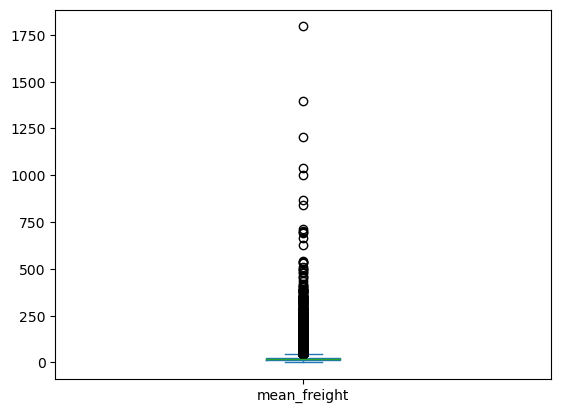

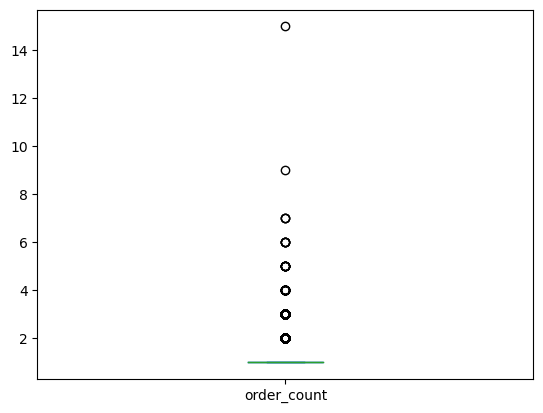

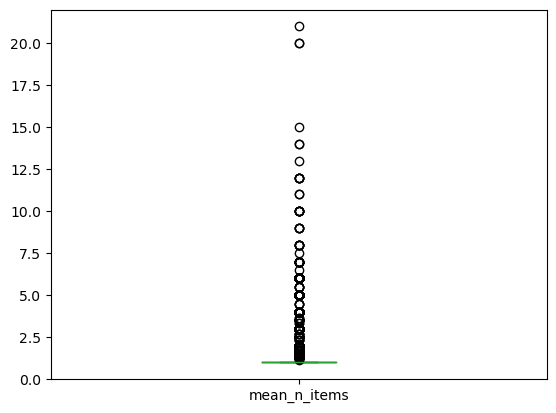

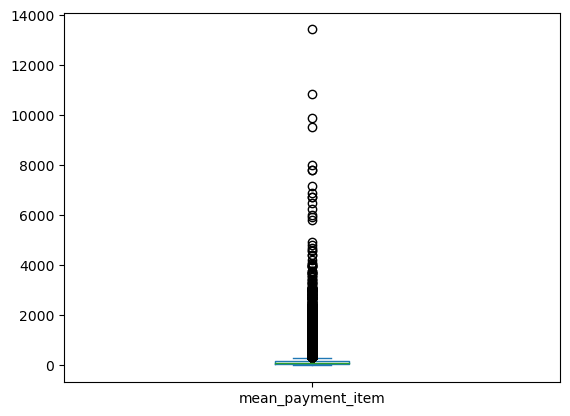

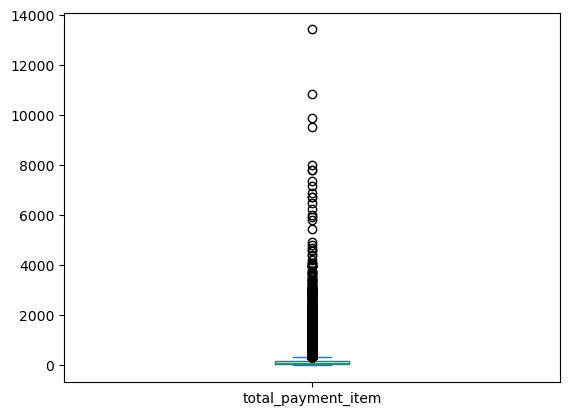

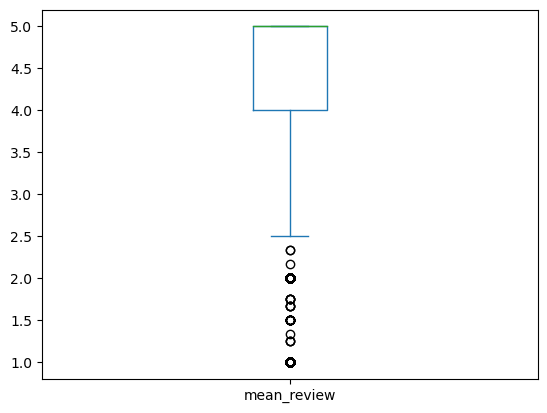

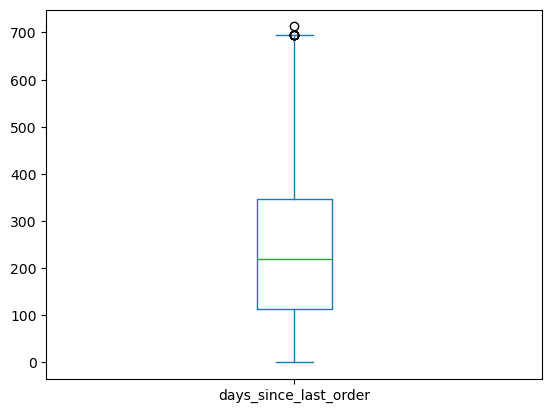

In [40]:
for col in data.drop(columns=['last_order','customer_unique_id']).columns : 
    plt.figure()
    data[col].plot(kind='box')

In [41]:
data.describe()

,mean_freight,order_count,mean_n_items,mean_payment_item,total_payment_item,mean_review,days_since_last_order
count,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,92755.000000,93358.000000
mean,23.897309,1.033420,1.139531,144.023212,148.637200,4.153643,237.519527
std,25.489320,0.209097,0.527075,238.259348,245.403864,1.280158,152.596929
min,0.000000,1.000000,1.000000,0.850000,0.850000,1.000000,0.000000
25%,14.100000,1.000000,1.000000,47.980000,48.900000,4.000000,114.000000
50%,17.600000,1.000000,1.000000,89.800000,89.900000,5.000000,219.000000
75%,25.630000,1.000000,1.000000,154.462500,159.900000,5.000000,346.000000
max,1794.960000,15.000000,21.000000,13440.000000,13440.000000,5.000000,713.000000


In [42]:
data[data['mean_payment_item']==13440]

,customer_unique_id,mean_freight,order_count,mean_n_items,last_order,mean_payment_item,total_payment_item,mean_review,days_since_last_order
3724,0a0a92112bd4c708ca5fde585afaa872,224.08,1,8.0,2017-09-29 15:24:52,13440.0,13440.0,1.0,334.0


In [43]:
data = data[data['total_payment_item']<5000]

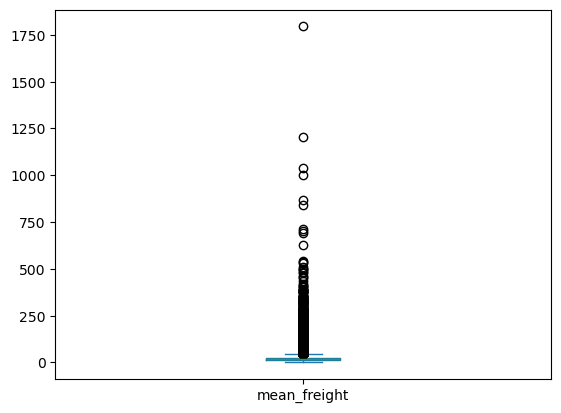

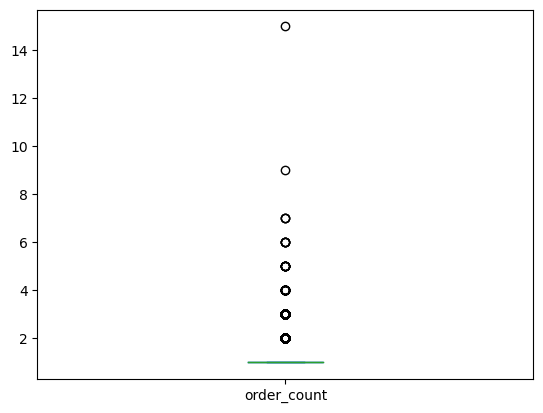

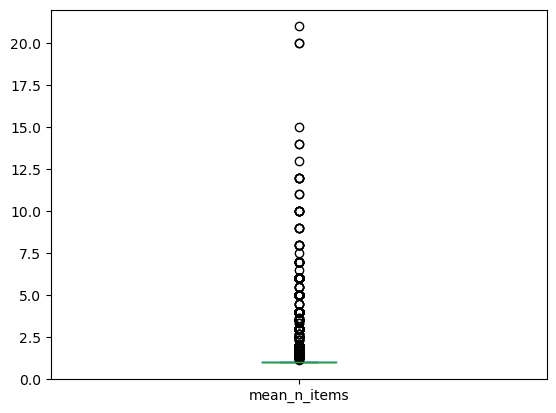

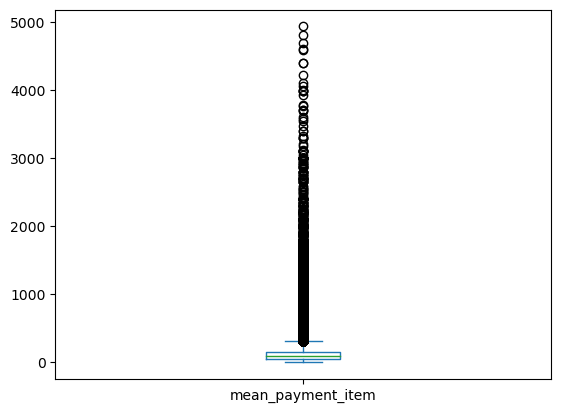

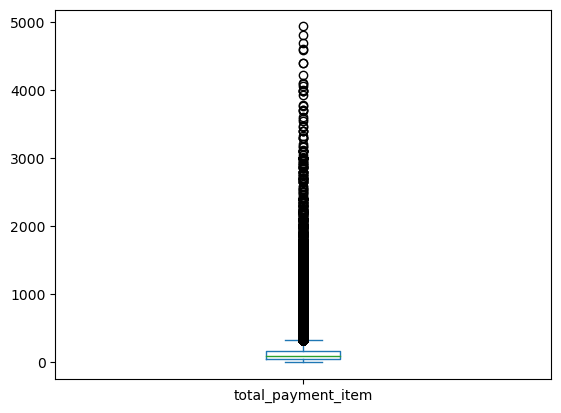

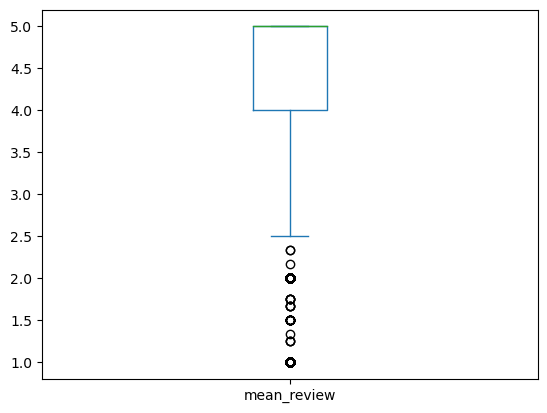

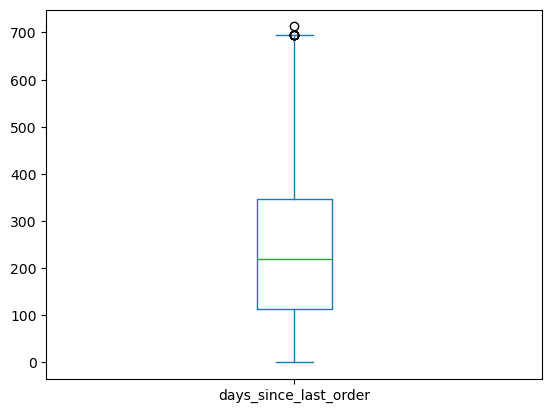

In [44]:
for col in data.drop(columns=['last_order','customer_unique_id']).columns : 
    plt.figure()
    data[col].plot(kind='box')

In [45]:
data.describe()

,mean_freight,order_count,mean_n_items,mean_payment_item,total_payment_item,mean_review,days_since_last_order
count,93340.000000,93340.000000,93340.000000,93340.000000,93340.000000,92738.000000,93340.000000
mean,23.831082,1.033405,1.139381,142.639368,147.185549,4.153708,237.506664
std,24.692829,0.209069,0.526312,213.819250,220.299354,1.280079,152.586902
min,0.000000,1.000000,1.000000,0.850000,0.850000,1.000000,0.000000
25%,14.100000,1.000000,1.000000,47.970000,48.900000,4.000000,114.000000
50%,17.600000,1.000000,1.000000,89.800000,89.900000,5.000000,219.000000
75%,25.630000,1.000000,1.000000,154.000000,159.900000,5.000000,346.000000
max,1794.960000,15.000000,21.000000,4931.910000,4931.910000,5.000000,713.000000


<AxesSubplot:>

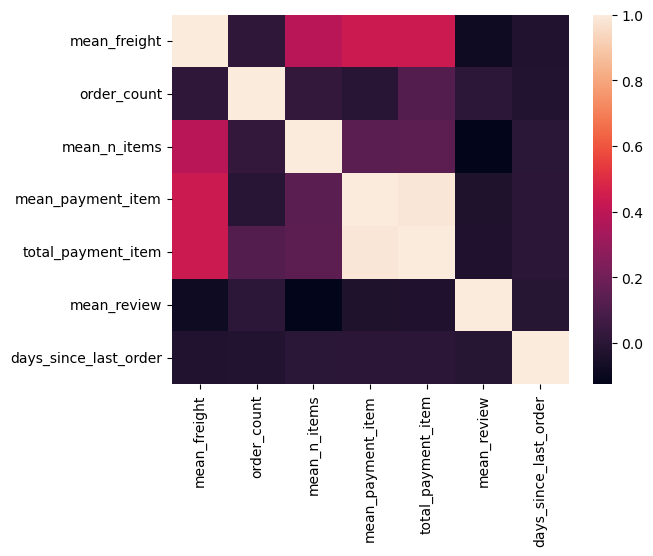

In [46]:
sns.heatmap(data.corr())

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93340 entries, 0 to 93357
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   customer_unique_id     93340 non-null  object        
 1   mean_freight           93340 non-null  float64       
 2   order_count            93340 non-null  int64         
 3   mean_n_items           93340 non-null  float64       
 4   last_order             93340 non-null  datetime64[ns]
 5   mean_payment_item      93340 non-null  float64       
 6   total_payment_item     93340 non-null  float64       
 7   mean_review            92738 non-null  float64       
 8   days_since_last_order  93340 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 7.1+ MB


In [48]:
data.to_csv('data.csv',index=False)